# <font style="color:rgb(50,120,229)">Find Objects using Image Features</font>


First, as usual, let's find ORB features in images and apply the ratio test to find the best matches.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
MAX_FEATURES = 1000
MIN_MATCH_COUNT = 10

In [4]:
# Read both images in grayscale mode
img1 = cv2.imread(DATA_PATH + 'images/book.jpeg')
img1Gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread(DATA_PATH + 'images/book_scene.jpeg')
img2Gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

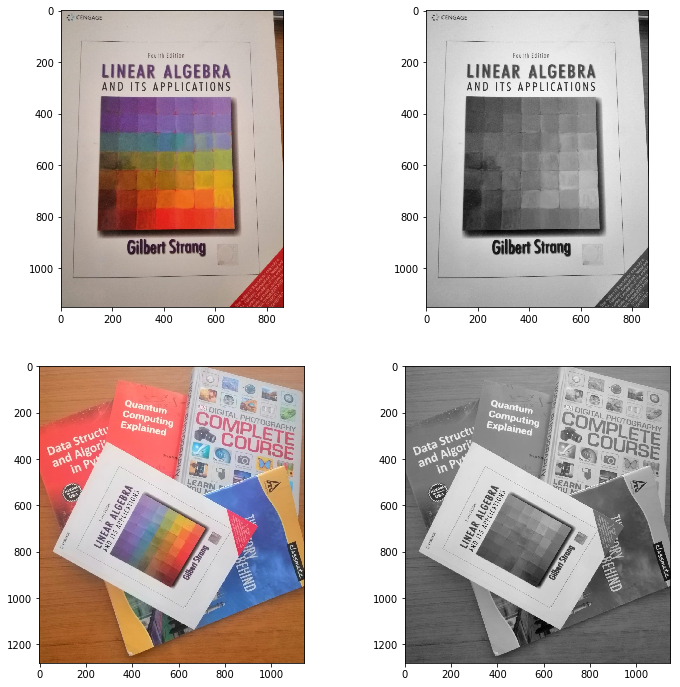

In [5]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(img1[:,:,::-1])
plt.subplot(2,2,2)
plt.imshow(img1Gray,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(img2[:,:,::-1])
plt.subplot(2,2,4)
plt.imshow(img2Gray,cmap='gray')
plt.show()

## <font style="color:rgb(50,120,229)">Find Features in both images </font>

In [6]:
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img1Gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2Gray, None)

## <font style="color:rgb(50,120,229)">Set up the matcher </font>

In [7]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

## <font style="color:rgb(50,120,229)">Find Matches or Corresponding points </font>

In [8]:
matches = flann.knnMatch(np.float32(descriptors1),np.float32(descriptors2),k=2)

## <font style="color:rgb(50,120,229)">Find good matches </font>

In [9]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)

Now we set a condition that atleast 10 matches (defined by `MIN_MATCH_COUNT`) are to be there to find the object. Otherwise simply show a message saying not enough matches are present.

If enough matches are found, we extract the locations of matched keypoints in both the images. They are passed to find the perpective transformation. Once we get this 3x3 transformation matrix, we use it to transform the corners of queryImage to corresponding points in trainImage. Then we draw it.

## <font style="color:rgb(50,120,229)">Find the location of the book in the cluttered image</font>
This is done in 2 steps:
1. First find the homography matrix using the corresponding points
1. We know the location of the book in the first image, thus, find the location of the 4 points in the cluttered image using the computed Homography.

In [10]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
#     Points in the original image
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
#     Find points in the Cluttered image corresponding to the book
    dst = cv2.perspectiveTransform(pts,M)
#     Draw a red box around the detected book
    img2 = cv2.polylines(img2,[np.int32(dst)],True,(0,0,255),10, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

Finally we draw our inliers (if successfully found the object) or matching keypoints (if failed).

## <font style="color:rgb(50,120,229)">Display the matches and the detected object</font>

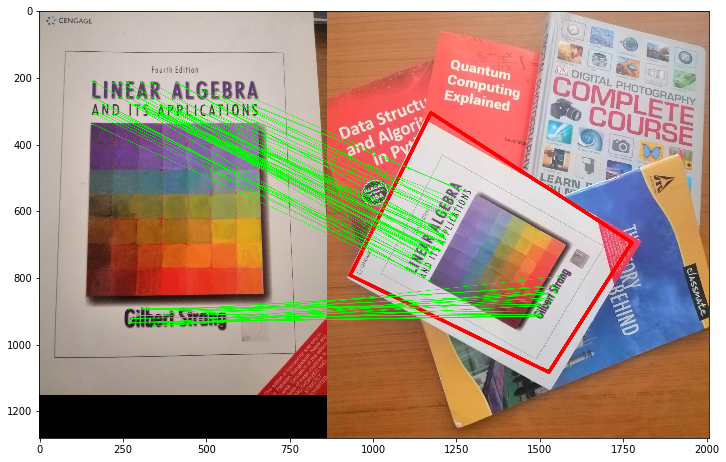

(<matplotlib.image.AxesImage at 0x7fe3f809f390>, None)

In [11]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,keypoints1,img2,keypoints2,good,None,**draw_params)

plt.figure(figsize=(12,12))
plt.imshow(img3[...,::-1]),plt.show()